# Reproducing "Robust Counterfactual Explanations on Graph Neural Networks"
This notebook represents our reproduction study where this notebook serves as a high-level interface.

In [ ]:
from explainer_main import main
from argparse import ArgumentParser
import json
import os
# !python -m pip install gdown
import gdown

os.environ["WANDB_MODE"] = "offline"  # Use wandb logging in offline mode

# Create empty saved_models directory
!rm -r saved_models
!mkdir saved_models

In [ ]:
SEEDS = [0, 1, 3, 5, 8, 10, 15, 42, 69, 101]  # All seeds during training and evaluating
SPARSITIES = [0.8, 1.0]  # Different train/tests splits: 0.8 represents 80/20 split; and 1.0 represents 100/100 split

# Create namespace with used hyperparameters
parser = ArgumentParser()
prog_args = parser.parse_args('')

with open('commandline_args.txt', 'r') as f:
    prog_args.__dict__ = json.load(f)

## Training
In this part we train multiple models on Mutagenicity and MNISTSuperPixel datasets.
Also you can download the pretrained versions instead below.

In [ ]:
TRAIN = False  # Set to False if you want to download our trained explainers on Mutagenicity. Set to True to train from scratch.

In [ ]:
if TRAIN is False:
    # Download pretrained models
    url = 'https://drive.google.com/uc?id=1G1cwd6XhQNzoe6_J0w162KrXwBxiciO6'
    gdown.download(url, quiet=False, use_cookies=False)
    !unzip models.zip -d ./saved_models/
    !mv ./saved_models/models/* ./saved_models/
    !rm -r ./saved_models/models
    !rm -r ./saved_models/__MACOSX
    !rm models.zip

In [ ]:
def train(args):
    if TRAIN is False:
        return
    
    for sparsity in SPARSITIES:
        args.train_data_sparsity = sparsity  # Set train/test split for all seeds
        for seed in SEEDS:
            args.seed = seed  # Set seed for training iteration
            main(args)

### RCExplainer

In [ ]:
# Train from scratch
prog_args.num_epochs = 1
prog_args.bmname = "Mutagenicity"  # Dataset used for training
prog_args.explainer_method = "rcexplainer"  # Explainer model to train
prog_args.prefix = "rcexp_mutag"  # Used for storing models and logging training

train(prog_args)

### RCExplainer NoLDB

In [ ]:
prog_args.num_epochs = 1
prog_args.bmname = "Mutagenicity"  # Dataset used for training
prog_args.explainer_method = "rcexp_noldb"  # Explainer model to train
prog_args.prefix = "rcexp_noldb_mutag"  # Used for storing models and logging training

train(prog_args)

### PGExplainer

In [ ]:
prog_args.num_epochs = 1
prog_args.bmname = "Mutagenicity"  # Dataset used for training
prog_args.explainer_method = "pgexplainer"  # Explainer model to train
prog_args.prefix = "pgexplainer_mutag"  # Used for storing models and logging training

train(prog_args)

## Evaluating
We evaluate all models trained on Mutagenicity dataset over 10 seeds on three different metrics.

In [ ]:
from get_results import get_all_results
results_dir = "RESULTS"

# Copy all models to saved_models directory for evaluating
if TRAIN is True:
    !cp -r ckpt/Mutagenicity/* saved_models

### Mutagenicity
We evaluate the model for all 10 seeds and two train/test splits.
The following cell evaluates all models trained on the Mutagenicity dataset and stores the evaluation results.

In [ ]:
get_all_results(results_dir)

#### Plot fidelity and ROC AUC scores

In [ ]:
from plot_graphs import plot_main

for f in os.listdir(results_dir):
    print(f)
    for file in os.listdir(results_dir + "/" + f):
        with open(results_dir + "/" + f + '/' + file, 'r') as g:
            print("Length of", file, len(json.load(g)))
    
    print()

plot_main(results_dir, 'fidelity', threshold=0)
plot_main(results_dir, 'noise')

### Efficency

In [ ]:
with open("timing_result.txt", "r") as f:
    print(f.readline())

# MNISTSuperPixel

In [ ]:
import sys
sys.path.append('./packages/gcn_interpretation/gnn-model-explainer')
sys.path.append('./packages/ldbExtraction')

from explainer_main import main
from argparse import ArgumentParser
import json
import os
os.environ["WANDB_MODE"] = "offline"  # Use wandb logging in offline mode

import os
from train import pyg_task as gcn_main
from train import arg_parse

### Downloading a pretrained GCN
The GCN can either be trained here or downloaded.

In [ ]:
# GNN
!pip install gdown
!gdown --id 1mYzpSdn2FXCk9mwLSPkqkopBphoJtT6j
!cp MNISTSuperpixels_base_h100_o30_BASE.pth.tar ./ckpt/MNISTSuperpixels_base_h100_o30.pth.tar


#PGExplainer
!gdown --id 1toctdLjdIH88JxRoYCqBliwY89fsPpsk
!cp pgexp_MNISTSuperpixelexplainer_MNISTSuperpixels_seed_0_sparsity_1_RIGHT_HYPERPARAMS.pth.tar ./ckpt/pgexp_MNISTSuperpixel_seed_0_sparsity_1_logdir_RIGHT_HYPERPARAMS/
    

#RCExplainer
!gdown --id 1hfu5TweqQhWoqNWXD0XnF1vwatDPa6-f
!cp rcexp_MNISTSuperpixelexplainer_MNISTSuperpixels_seed_0_sparsity_1_RIGHT_HYPERPARMS.pth.tar ./ckpt/rcexp_MNISTSuperpixel_seed_0_sparsity_1_logdir_RIGHT_HYPERPARAMS/

### Training the GCN on MNISTSuperpixels
Training might not work in the notebook as jupyter does not free memory.
Run this command from the terminal to obtain the same result.
```python3 train.py --bmname MNISTSuperpixels --gpu --datadir data --num-classes 10 --hidden-dim 100 --output-dim 30 --num-gc-layers 4```

In [ ]:
prog_args = arg_parse("")
prog_args.bmname = "MNISTSuperpixels"
prog_args.gpu = True
prog_args.datadir = "data"

prog_args.num_gc_layers = 4
prog_args.num_classes = 10
prog_args.hidden_dim = 100
prog_args.output_dim = 30

prog_args.num_epochs = 1
gcn_main(prog_args)

### Training RCExplainer
The evaluation may not work in the notebook. Run this command from the terminal to obtain the same result.
```python explainer_main.py --bmname MNISTSuperpixels --graph-mode --num-gc-layers 4 --explainer-method rcexplainer --gpu --ckptdir "./ckpt" --multigraph-class 0  --prefix "rcexp_MNISTSuperpixel_TestTrainSplit"  --bloss-version "sigmoid" --epochs 601 --hidden-dim 100 --output-dim 30 --train-data-sparsity .8 --seed 12345```

In [ ]:
import configs

prog_args = configs.arg_parse("")
prog_args.bmname = "MNISTSuperpixels"
prog_args.gpu = False
prog_args.datadir = "data"
prog_args.num_classes = 10
prog_args.graph_mode = True
prog_args.explainer_method = "rcexplainer"
prog_args.ckptdir = "./ckpt"
prog_args.multigraph_class = 0
prog_args.prefix = "rcexp_MNISTSuperpixel"
prog_args.lr = 0.001
prog_args.size_c = 0.001
prog_args.ent_c = 8.0
prog_args.boundary_c = 3
prog_args.inverse_boundary_c = 12
prog_args.bloss_version = "sigmoid"
prog_args.train_data_sparsity = 1

prog_args.num_gc_layers = 4
prog_args.hidden_dim = 100
prog_args.output_dim = 30

prog_args.num_epochs = 1


In [ ]:
# Train RCExplainer
_ = main(prog_args)

### Evaluate RCExplainer
The evaluation may not work in the notebook. Run this command from the terminal to obtain the same result.
```python explainer_main.py --bmname MNISTSuperpixels --graph-mode --num-gc-layers 4 --explainer-method rcexplainer --gpu --ckptdir "./ckpt" --multigraph-class 0  --prefix "rcexp_MNISTSuperpixel_TestTrainSplit"  --bloss-version "sigmoid" --epochs 601 --hidden-dim 100 --output-dim 30 --train-data-sparsity .8 --seed 12345 --exp-path ckpt/rcexp_MNISTSuperpixel_seed_0_sparsity_1_logdir_RIGHT_HYPERPARAMS/rcexp_MNISTSuperpixelexplainer_MNISTSuperpixels_seed_0_sparsity_1_RIGHT_HYPERPARMS.pth.tar --eval --noise```

In [ ]:
prog_args.eval = True
prog_args.noise = True
prog_args.exp_path = "ckpt/rcexp_MNISTSuperpixel_seed_0_sparsity_1_logdir_RIGHT_HYPERPARAMS/rcexp_MNISTSuperpixelexplainer_MNISTSuperpixels_seed_0_sparsity_1_RIGHT_HYPERPARMS.pth.tar"

rcexp_result = main(prog_args)

In [ ]:
# get test-set results
rc_SPARSITY, rc_FIDELITY, NOISE_VALS, rc_AUC = rcexp_result[1] 

### Training PGExplainer
The evaluation may not work in the notebook. Run this command from the terminal to obtain the same result.
```python explainer_main.py --bmname MNISTSuperpixels --graph-mode --num-gc-layers 4 --explainer-method rcexplainer --gpu --ckptdir "./ckpt" --multigraph-class 0  --prefix "rcexp_MNISTSuperpixel_TestTrainSplit"  --bloss-version "sigmoid" --epochs 601 --hidden-dim 100 --output-dim 30 --train-data-sparsity .8 --seed 12345 ```

In [ ]:
import configs


prog_args = configs.arg_parse("")
prog_args.bmname = "MNISTSuperpixels"
prog_args.gpu = False
prog_args.datadir = "data"
prog_args.num_classes = 10
prog_args.graph_mode = True
prog_args.explainer_method = "pgexplainer"
prog_args.ckptdir = "./ckpt"
prog_args.multigraph_class = 0
prog_args.prefix = "pgexp_MNISTSuperpixel"
prog_args.lr = 0.001
prog_args.size_c = 0.001
prog_args.ent_c = 8.0
prog_args.boundary_c = 3
prog_args.inverse_boundary_c = 12
prog_args.bloss_version = "sigmoid"
prog_args.train_data_sparsity = 1

prog_args.num_gc_layers = 4
prog_args.hidden_dim = 100
prog_args.output_dim = 30

prog_args.num_epochs = 1

_ = main(prog_args)

In [ ]:
# Train PGExplainer
_ = main(prog_args)

### Evaluate PGExplainer
The evaluation may not work in the notebook. Run this command from the terminal to obtain the same result.
```python explainer_main.py --bmname MNISTSuperpixels --graph-mode --num-gc-layers 4 --explainer-method rcexplainer --gpu --ckptdir "./ckpt" --multigraph-class 0  --prefix "rcexp_MNISTSuperpixel_TestTrainSplit"  --bloss-version "sigmoid" --epochs 601 --hidden-dim 100 --output-dim 30 --name-suffix BASE --train-data-sparsity .8 --seed 12345 --exp-path ./ckpt/pgexp_MNISTSuperpixel_seed_0_sparsity_1_logdir_RIGHT_HYPERPARAMS/pgexp_MNISTSuperpixelexplainer_MNISTSuperpixels_seed_0_sparsity_1_RIGHT_HYPERPARAMS.pth.tar --eval --noise```

In [ ]:

prog_args.eval = True
prog_args.noise = True
prog_args.exp_path = "./ckpt/pgexp_MNISTSuperpixel_seed_0_sparsity_1_logdir_RIGHT_HYPERPARAMS/pgexp_MNISTSuperpixelexplainer_MNISTSuperpixels_seed_0_sparsity_1_RIGHT_HYPERPARAMS.pth.tar"

pgexp_result  = main(prog_args)

In [ ]:
# get test-set results
pg_SPARSITY, pg_FIDELITY, NOISE_VALS, pg_AUC = = pgexp_result[1] 

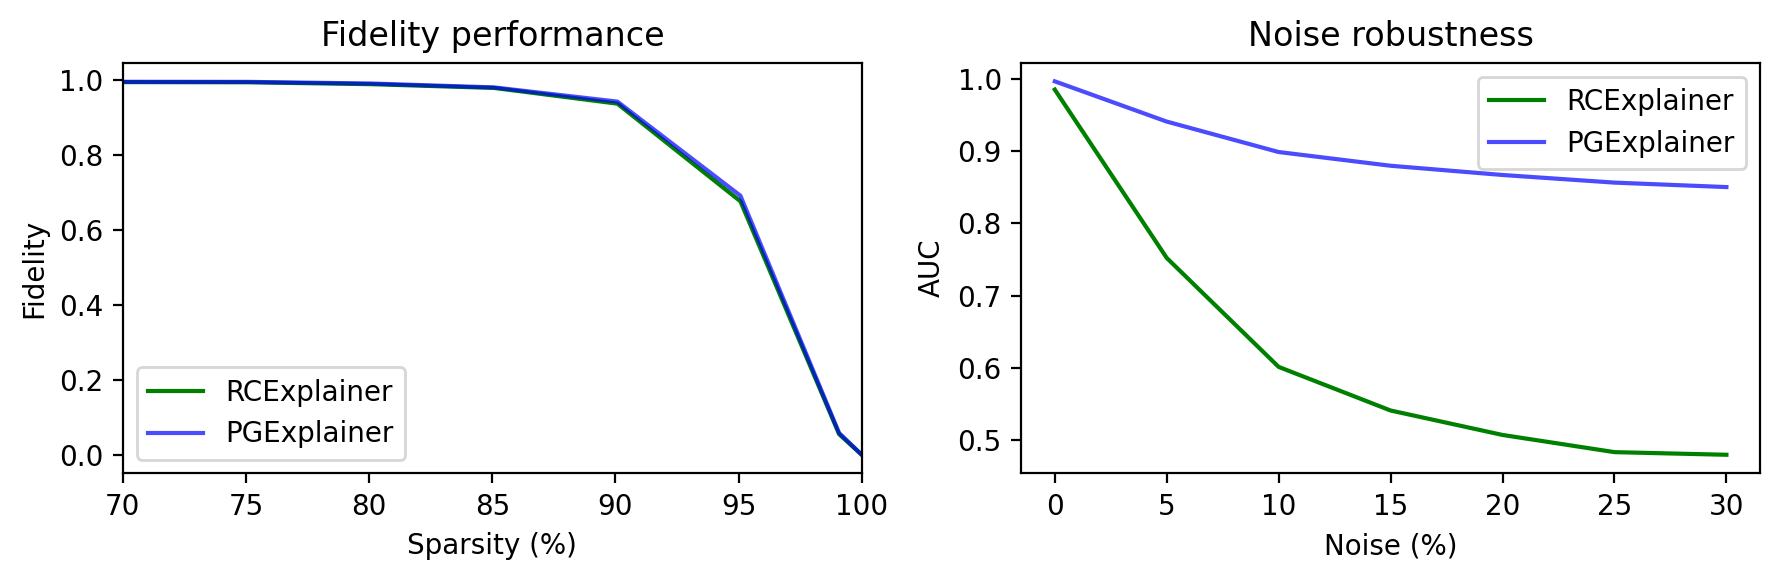

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

S = 3
fig, axs = plt.subplots(1,2, figsize=(S*3,S),dpi=200)
axs[0].set_title("Fidelity performance")

axs[0].plot(np.array(rc_SPARSITY) * 100, rc_FIDELITY,  label="RCExplainer", color="green")
axs[0].plot(np.array(pg_SPARSITY) * 100, pg_FIDELITY,  alpha=.7,  label="PGExplainer", color="blue", )

axs[0].set_xlim(70, 100)
axs[0].set_xlabel("Sparsity (%)")
axs[0].set_ylabel("Fidelity")


axs[1].set_title("Noise robustness")

NOISE_VALS = np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]) * 100
axs[1].plot(NOISE_VALS, rc_AUC, label="RCExplainer", color="green")
axs[1].plot(NOISE_VALS, pg_AUC, alpha=.7, label="PGExplainer", color="blue")

axs[1].set_xlabel("Noise (%)")
axs[1].set_ylabel("AUC")
axs[0].legend(loc="lower left")
axs[1].legend()
plt.tight_layout()

plt.show()